<a href="https://colab.research.google.com/github/rogerzmukiibi/100daysofml.github.io/blob/main/NASA_and_CAMSRAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Accessing Github data files from colab
from google.colab import userdata
token = userdata.get('github')
!git clone -b rm/data_cleaning https://{token}@github.com/Marconi-Lab/Solar_irradiation.git

Cloning into 'Solar_irradiation'...
remote: Enumerating objects: 19439, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 19439 (delta 25), reused 28 (delta 15), pack-reused 19358 (from 3)
Receiving objects: 100% (19439/19439), 245.42 MiB | 20.44 MiB/s, done.
Resolving deltas: 100% (2927/2927), done.


In [ ]:
!git clone https://github.com/NREL/rest2.git

Cloning into 'rest2'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 138 (delta 58), reused 98 (delta 30), pack-reused 0 (from 0)
Receiving objects: 100% (138/138), 14.79 MiB | 26.06 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [ ]:
#@title Imports
!pip install pvlib --q
import pvlib
from pathlib import Path
import requests
import pandas as pd
import numpy as np
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns
from requests.exceptions import Timeout

In [ ]:
#@title Directories
measurement_folder = Path("/content/Solar_irradiation/jupyter_notebooks/Data/irradiation_measurements")
ministry_folder = measurement_folder / 'ministry_energy_ug'
cbe_folder = measurement_folder / 'CBE_Data'
ministry_file = list(ministry_folder.glob('*.csv'))
cbe_file = list(cbe_folder.glob('*.csv'))
all_files = ministry_file + cbe_file
all_files.sort()


In [ ]:
#@title Compute altitude
def get_altitude_pvib(df):

    locations = df['location'].unique()

    for location in locations:
        latitude = df[df['location'] == location]['latitude'].iloc[0]
        longitude = df[df['location'] == location]['longitude'].iloc[0]
        altitude = pvlib.location.lookup_altitude(latitude, longitude)
        df.loc[df['location'] == location, 'altitude'] = altitude

    return df

In [ ]:
locations = [
    'egypt', 'ghana', 'kenya', 'madagascar',
    'nigeria', 'somalia', 'soroti', 'wadelai'
]
df = pd.DataFrame()
# read files for each location from all_files
for loc in locations:
    for file in all_files:
        if loc in file.name:
            df_temp = pd.read_csv(file)
            df = pd.concat([df, df_temp], ignore_index=True)

In [ ]:
df[df['location']=='kenya_location3']

,datetime,ghi_ground,location,latitude,longitude
8208,2019-05-28,4589.500,kenya_location3,-0.469974,35.181874
8209,2019-05-29,6477.250,kenya_location3,-0.469974,35.181874
8210,2019-05-30,4090.750,kenya_location3,-0.469974,35.181874
8211,2019-05-31,5965.750,kenya_location3,-0.469974,35.181874
8212,2019-06-01,3729.500,kenya_location3,-0.469974,35.181874
...,...,...,...,...,...
10179,2024-11-21,3062.517,kenya_location3,-0.469974,35.181874
10180,2024-11-22,3192.050,kenya_location3,-0.469974,35.181874
10181,2024-11-23,5871.390,kenya_location3,-0.469974,35.181874
10182,2024-11-24,4051.274,kenya_location3,-0.469974,35.181874


In [ ]:
def extract_location_metadata(df):
    """
    Reads the time range of the ground data and the coordinates of the station

    Args:
        df (pd.DataFrame): Dataframe with the ground data

    Returns:
        dictionary: Dictionary with the time range, location and coordinates
    """
    if not all(col in df.columns for col in ['location', 'datetime', 'latitude', 'longitude']):
        raise ValueError("Input DataFrame must contain 'location', 'datetime', 'latitude', 'longitude' columns.")
    if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
         df['datetime'] = pd.to_datetime(df['datetime'])

    locations = df['location'].unique()
    metadata_dict = {}

    for location in locations:
        location_df = df[df['location'] == location].copy()
        start_time = location_df['datetime'].min()
        end_time = location_df['datetime'].max()

        # Get the coordinates from the first row
        lat = location_df['latitude'].iloc[0]
        lon = location_df['longitude'].iloc[0]

        metadata = {
            'Location': location,
            'Start Time': start_time.strftime('%Y-%m-%d'),
            'End Time': end_time.strftime('%Y-%m-%d'),
            'Latitude': lat,
            'Longitude': lon
        }
        metadata_dict[location] = metadata
    return metadata_dict
loc_dict = {}
loc_dict = extract_location_metadata(df)

In [ ]:
#@title NASA parameters
parameters_dict = {
    'Temperature at 2 Meters': 'T2M',
    'All Sky Surface Shortwave Downward Irradiance': 'ALLSKY_SFC_SW_DWN',
    'Relative Humidity at 2 Meters': 'RH2M',
    'Wind Speed at 2 Meters': 'WS2M',
    'Dew/Frost Point at 2 Meters': 'T2MDEW',
    'Temperature at 2 Meters Maximum': 'T2M_MAX',
    'Temperature at 2 Meters Minimum': 'T2M_MIN',
    'Surface Pressure': 'PS',
    'Wet Bulb Temperature at 2 Meters': 'T2MWET',
    'All Sky Surface Longwave Downward Irradiance': 'ALLSKY_SFC_LW_DWN',
    'All Sky Surface Shortwave Diffuse Irradiance': 'ALLSKY_SFC_SW_DIFF',
    'All Sky Surface Shortwave Downward Direct Normal Irradiance': 'ALLSKY_SFC_SW_DNI',
    'All Sky Surface Albedo': 'ALLSKY_SRF_ALB',
    'Cloud Amount': 'CLOUD_AMT',
    'Precipitation Corrected': 'PRECTOTCORR',
    'Top-Of-Atmosphere Shortwave Downward Irradiance': 'TOA_SW_DWN',
    'Profile Soil Moisture': 'GWETPROF',
    'Earth Skin Temperature': 'TS',
    'All Sky Surface Total PAR': 'ALLSKY_SFC_PAR_TOT',
    'Specific Humidity at 2 Meters': 'QV2M',
    'Temperature at 2 Meters Range': 'T2M_RANGE',
    'All Sky Insolation Clearness Index': 'ALLSKY_KT',
    'Clear Sky Surface Shortwave Downward Irradiance': 'CLRSKY_SFC_SW_DWN',
    'Root Zone Soil Wetness': 'GWETROOT',
    'Surface Soil Wetness': 'GWETTOP',
    'All Sky Surface UVA Irradiance': 'ALLSKY_SFC_UVA',
    'All Sky Surface UVB Irradiance': 'ALLSKY_SFC_UVB',
    'All Sky Surface UV Index': 'ALLSKY_SFC_UV_INDEX',
    'Clear Sky Insolation Clearness Index': 'CLRSKY_KT',
    'Clear Sky Surface Total PAR': 'CLRSKY_SFC_PAR_TOT',
    'Precipitable Water': 'PW',
    'Air Mass': 'AIRMASS',
    'All Sky Normalized Insolation Clearness Index': 'ALLSKY_NKT',
    'All Sky Surface Longwave Upward Irradiance': 'ALLSKY_SFC_LW_UP',
    'All Sky Surface Diffuse PAR': 'ALLSKY_SFC_PAR_DIFF',
    'All Sky Surface Direct Horizontal PAR': 'ALLSKY_SFC_PAR_DIRH',
    'All Sky Surface Shortwave Direct Horizontal Irradiance': 'ALLSKY_SFC_SW_DIRH',
    'All Sky Surface Shortwave Upward Irradiance': 'ALLSKY_SFC_SW_UP',
    'Adjusted Aerosol Optical Depth 55': 'AOD_55_ADJ',
    'Aerosol Optical Depth 84': 'AOD_84',
    'Cloud Optical Visible Depth': 'CLOUD_OD',
    'Clear Sky Days': 'CLRSKY_DAYS',
    'Clear Sky Normalized Insolation Clearness Index': 'CLRSKY_NKT',
    'Clear Sky Surface Longwave Downward Irradiance': 'CLRSKY_SFC_LW_DWN',
    'Clear Sky Surface Longwave Upward Irradiance': 'CLRSKY_SFC_LW_UP',
    'Clear Sky Surface Diffuse PAR': 'CLRSKY_SFC_PAR_DIFF',
    'Clear Sky Surface Direct Horizontal PAR': 'CLRSKY_SFC_PAR_DIRH',
    'Clear Sky Surface Shortwave Downward Diffuse Irradiance': 'CLRSKY_SFC_SW_DIFF',
    'Clear Sky Surface Shortwave Direct Horizontal Irradiance': 'CLRSKY_SFC_SW_DIRH',
    'Clear Sky Surface Shortwave Downward Direct Normal Irradiance': 'CLRSKY_SFC_SW_DNI',
    'Clear Sky Surface Shortwave Upward Irradiance': 'CLRSKY_SFC_SW_UP',
    'Clear Sky Surface Albedo': 'CLRSKY_SRF_ALB',
    'Zero Plane Displacement Height': 'DISPH',
    'Evaporation Land': 'EVLAND',
    'Evapotranspiration Energy Flux': 'EVPTRNS',
    'Ice Covered Fraction': 'FRSEAICE',
    'Planetary Boundary Layer Top Pressure': 'PBLTOP',
    'Peak Sun Hour': 'PSH',
    'Surface Air Density': 'RHOA',
    'Surface Albedo Adjusted': 'SRF_ALB_ADJ',
    'Total Column Ozone': 'TO3',
    'Total Column Precipitable Water': 'TQV',
    'Eastward Wind at 2 Meters': 'U2M',
    'Northward Wind at 2 Meters': 'V2M',
    'Surface Roughness': 'Z0M'
}
parameters_array = list(parameters_dict.values())

In [ ]:
#@title Nasa pull
import pandas as pd
import requests
from io import StringIO
import math
import time
from requests.exceptions import Timeout


NASA_POWER_BATCH_SIZE = 20
NASA_POWER_BASE_URL = "https://power.larc.nasa.gov/api/temporal/daily/point?parameters={parameters_str}&community=RE&longitude={longitude}&latitude={latitude}&start={start}&end={end}&format=CSV"
NASA_MISSING_VALUE = -999

def fetch_nasa_power_data_batched(locations_dict, parameters_list, estimator="nasa_power", request_delay_sec=0.001):
    """
    Fetch daily data from NASA POWER API for multiple locations, handling parameter batching.

    Args:
        locations_dict (dict): Dictionary with location details from extract_location_metadata.
        parameters_list (list): List of strings for ALL desired NASA POWER parameters.
        estimator (str): Name to assign to the 'estimator' column.
        request_delay_sec (float): Optional delay (in seconds) between API requests to avoid
                                   hitting rate limits. Default is 0.5 seconds.

    Returns:
        tuple: (pd.DataFrame, dict)
            - DataFrame containing data for ALL requested parameters and locations,
              with columns for each parameter, plus 'location' and 'estimator'.
              Index is datetime.
            - Dictionary containing metadata strings for each location (from the first batch).
            Returns (pd.DataFrame(), {}) if fetching fails significantly.
    """
    if not isinstance(parameters_list, (list, tuple)):
        raise TypeError("`parameters_list` must be a list or tuple of parameter strings.")
    if not parameters_list:
        print("Warning: No parameters provided to fetch_nasa_power_data_batched.")
        return pd.DataFrame(), {}

    num_batches = math.ceil(len(parameters_list) / NASA_POWER_BATCH_SIZE)

    all_location_final_dfs = []
    metadata_dict = {}

    for location_name, details in locations_dict.items():
        start_date_api = details['Start Time'].replace("-", "")
        end_date_api = details['End Time'].replace("-", "")
        latitude = details['Latitude']
        longitude = details['Longitude']

        location_batch_dfs = []

        for i in range(num_batches):
            batch_start_idx = i * NASA_POWER_BATCH_SIZE
            batch_end_idx = batch_start_idx + NASA_POWER_BATCH_SIZE
            parameter_batch = parameters_list[batch_start_idx:batch_end_idx]
            parameters_str = ",".join(parameter_batch)

            api_url = NASA_POWER_BASE_URL.format(
                parameters_str=parameters_str,
                longitude=longitude,
                latitude=latitude,
                start=start_date_api,
                end=end_date_api
            )

            try:
                # Optional delay between requests
                # if request_delay_sec > 0 and (i > 0 or list(locations_dict.keys())[0] != location_name):
                #      time.sleep(request_delay_sec)

                response = requests.get(api_url, verify=True, timeout=90)
                response.raise_for_status()

                content = response.content.decode('utf-8')
                lines = content.split("\n")

                try:
                    header_row_index = next(i for i, line in enumerate(lines) if line.strip().startswith("YEAR,MO,DY"))
                except StopIteration:
                    print(f"  Warning: Could not find standard header 'YEAR,MO,DY...' in NASA POWER response for batch {i+1}, location {location_name}. Skipping batch.")
                    print(f"  Response content start:\n{content[:500]}")
                    continue

                if location_name not in metadata_dict:
                     metadata = "\n".join(lines[:header_row_index])
                     metadata_dict[location_name] = {"metadata": metadata}

                csv_data = StringIO("\n".join(lines[header_row_index:]))
                df_batch = pd.read_csv(csv_data, na_values={col: NASA_MISSING_VALUE for col in parameter_batch})


                if not all(col in df_batch.columns for col in ['YEAR', 'MO', 'DY']):
                     print(f"  Warning: Missing YEAR, MO, or DY columns in batch {i+1}, location {location_name}. Skipping batch.")
                     continue
                df_batch.rename(columns={"YEAR": "year", "MO": "month", "DY": "day"}, inplace=True)
                df_batch["datetime"] = pd.to_datetime(df_batch[["year", "month", "day"]])
                df_batch.set_index('datetime', inplace=True)

                cols_to_keep = [col for col in parameter_batch if col in df_batch.columns]
                if len(cols_to_keep) != len(parameter_batch):
                     missing_cols = set(parameter_batch) - set(cols_to_keep)
                     print(f"  Warning: Did not find all expected parameter columns in response for batch {i+1}. Missing: {missing_cols}")

                if not cols_to_keep:
                    print(f"  Warning: No valid parameter columns found in batch {i+1}, location {location_name}. Skipping batch.")
                    continue

                df_batch = df_batch[cols_to_keep]

                for col in df_batch.columns:
                    df_batch[col] = pd.to_numeric(df_batch[col], errors='coerce')

                location_batch_dfs.append(df_batch)


            except Timeout:
                 print(f"  Timeout error fetching NASA POWER data for batch {i+1}, location {location_name}")
            except requests.exceptions.RequestException as e:
                 print(f"  Failed to fetch NASA POWER data for batch {i+1}, location {location_name}: {e}")
            except Exception as e:
                 print(f"  An unexpected error occurred processing NASA POWER batch {i+1} for {location_name}: {e}")

        if location_batch_dfs:
            combined_loc_df = pd.concat(location_batch_dfs, axis=1)

            if combined_loc_df.columns.has_duplicates:
                 print(f"  Warning: Duplicate columns found after merging batches for {location_name}. Keeping first instance.")
                 combined_loc_df = combined_loc_df.loc[:, ~combined_loc_df.columns.duplicated(keep='first')]

            combined_loc_df['location'] = location_name
            combined_loc_df['estimator'] = estimator
            all_location_final_dfs.append(combined_loc_df)
            print(f"--- Finished processing location: {location_name} ---")
        else:
            print(f"--- No data successfully processed for location: {location_name} ---")

    if not all_location_final_dfs:
        print("\nNo NASA POWER data successfully fetched for any location.")
        return pd.DataFrame(), metadata_dict

    final_df = pd.concat(all_location_final_dfs, axis=0)

    id_cols = ['location', 'estimator']
    data_cols = [col for col in final_df.columns if col not in id_cols]
    final_df = final_df[id_cols + data_cols]

    print(f"\nSuccessfully combined NASA POWER data for {len(locations_dict)} locations.")
    return final_df, metadata_dict




nasa_df, nasa_meta = fetch_nasa_power_data_batched(
    loc_dict,
    parameters_list=parameters_array
)

In [ ]:
nasa_df['ghi_nasa'] = nasa_df['ALLSKY_SFC_SW_DWN'] * 1000

In [ ]:
#@title Cams Fetch
def fetch_cams_data(locations_dict, email, time_step='1d', identifier='cams_radiation', estimator='cams'):
    """
    Fetch CAMS radiation data for multiple locations using pvlib.

    Args:
        locations_dict (dict): Dictionary with location details from extract_location_metadata.
        email (str): Email address required for CAMS service.
        time_step (str): Time step for CAMS data (e.g., '1h', '1d'). Defaults to '1d'.
        identifier (str): CAMS service identifier (e.g., 'cams_radiation').
        estimator (str): Name to assign to the 'estimator' column.

    Returns:
        pd.DataFrame: DataFrame containing formatted CAMS data for all locations.
                      Returns an empty DataFrame if fetching fails for all locations.
    """
    all_data = []
    ghi_cols = ['ghi_extra', 'ghi_clear', 'bhi_clear', 'dhi_clear', 'dni_clear', 'ghi', 'bhi', 'dhi', 'dni']

    for location_name, details in locations_dict.items():
        print(f"Fetching CAMS data for: {location_name} ({details['Start Time']} to {details['End Time']})")
        try:
            start_dt = pd.to_datetime(details['Start Time'])
            end_dt = pd.to_datetime(details['End Time'])

            data, metadata = pvlib.iotools.get_cams(
                latitude=details['Latitude'],
                longitude=details['Longitude'],
                start=start_dt,
                end=end_dt,
                email=email,
                time_step=time_step,
                identifier=identifier,
                timeout=180
            )
            # convert from W/m^2 to Wh/m^2
            for col in ghi_cols:
                data[col] = data[col] * 24

            df_loc = data.copy()

            df_loc['location'] = location_name
            df_loc['estimator'] = estimator

            df_loc.index.name = 'datetime'

            all_data.append(df_loc)

        except Timeout:
             print(f"Timeout error fetching CAMS data for {location_name}")
        except requests.exceptions.RequestException as e: # pvlib uses requests internally
             print(f"Network error fetching CAMS data for {location_name}: {e}")
        except ImportError:
            raise ImportError("pvlib library is required for CAMS fetching. Please install it.")
        except Exception as e:
            print(f"Failed to fetch or process CAMS data for {location_name}: {e}") # Print the error


    if not all_data:
        print("No CAMS data successfully fetched.")
        return pd.DataFrame()

    final_df = pd.concat(all_data)
    return final_df

cams_email = 'mukiibirogerz@gmail.com'
cams_df = fetch_cams_data(loc_dict, email=cams_email)

Fetching CAMS data for: egypt_location1 (2023-09-01 to 2024-11-25)
Fetching CAMS data for: ghana_location1 (2019-09-24 to 2024-11-25)
Fetching CAMS data for: ghana_location2 (2020-01-31 to 2024-05-02)
Fetching CAMS data for: ghana_location3 (2021-02-25 to 2024-11-25)
Fetching CAMS data for: kenya_location10 (2023-10-26 to 2024-11-25)
Fetching CAMS data for: kenya_location11 (2024-03-02 to 2024-11-25)
Fetching CAMS data for: kenya_location12 (2024-02-09 to 2024-11-25)
Fetching CAMS data for: kenya_location13 (2023-10-25 to 2024-11-25)
Fetching CAMS data for: kenya_location14 (2023-10-25 to 2024-11-25)
Fetching CAMS data for: kenya_location2 (2019-10-08 to 2024-02-23)
Fetching CAMS data for: kenya_location3 (2019-05-28 to 2024-11-25)
Fetching CAMS data for: kenya_location4 (2019-07-24 to 2022-01-28)
Fetching CAMS data for: kenya_location5 (2020-12-22 to 2024-11-25)
Fetching CAMS data for: kenya_location6 (2021-01-13 to 2024-11-25)
Fetching CAMS data for: kenya_location7 (2021-01-12 to 20

In [ ]:
print(f'nasa shape: {nasa_df.shape}')
print(f'cams shape: {cams_df.shape}')
print(f'df shape: {df.shape}')

nasa shape: (21179, 68)
cams shape: (21179, 11)
df shape: (19931, 5)


In [ ]:
merged_df = pd.read_csv('merged_df.csv')
merged_df['datetime'] = pd.to_datetime(merged_df['datetime'])

In [ ]:
# combine dataframes nasa_df, df and cams_df on datetime and location
df_final = pd.merge(merged_df, cams_df, on=['datetime', 'location'], how='outer')

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 80 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             22552 non-null  datetime64[ns]
 1   location             22552 non-null  object        
 2   T2M                  22552 non-null  float64       
 3   ALLSKY_SFC_SW_DWN    22549 non-null  float64       
 4   RH2M                 22552 non-null  float64       
 5   WS2M                 22552 non-null  float64       
 6   T2MDEW               22552 non-null  float64       
 7   T2M_MAX              22552 non-null  float64       
 8   T2M_MIN              22552 non-null  float64       
 9   PS                   22552 non-null  float64       
 10  T2MWET               22552 non-null  float64       
 11  ALLSKY_SFC_LW_DWN    22552 non-null  float64       
 12  ALLSKY_SFC_SW_DIFF   20016 non-null  float64       
 13  ALLSKY_SFC_SW_DNI    20016 non-

In [ ]:
# show me row with null values
df_nan = df_final[df_final.isnull().any(axis=1)]

In [ ]:
# drop rows in df_nan wirh ghi_ground = nan
df_nan = df_nan.dropna(subset=['ghi_ground'])

In [ ]:
!ls

merged_df.csv  rest2  sample_data  Solar_irradiation


In [ ]:
merged_df = pd.read_csv('merged_df.csv')

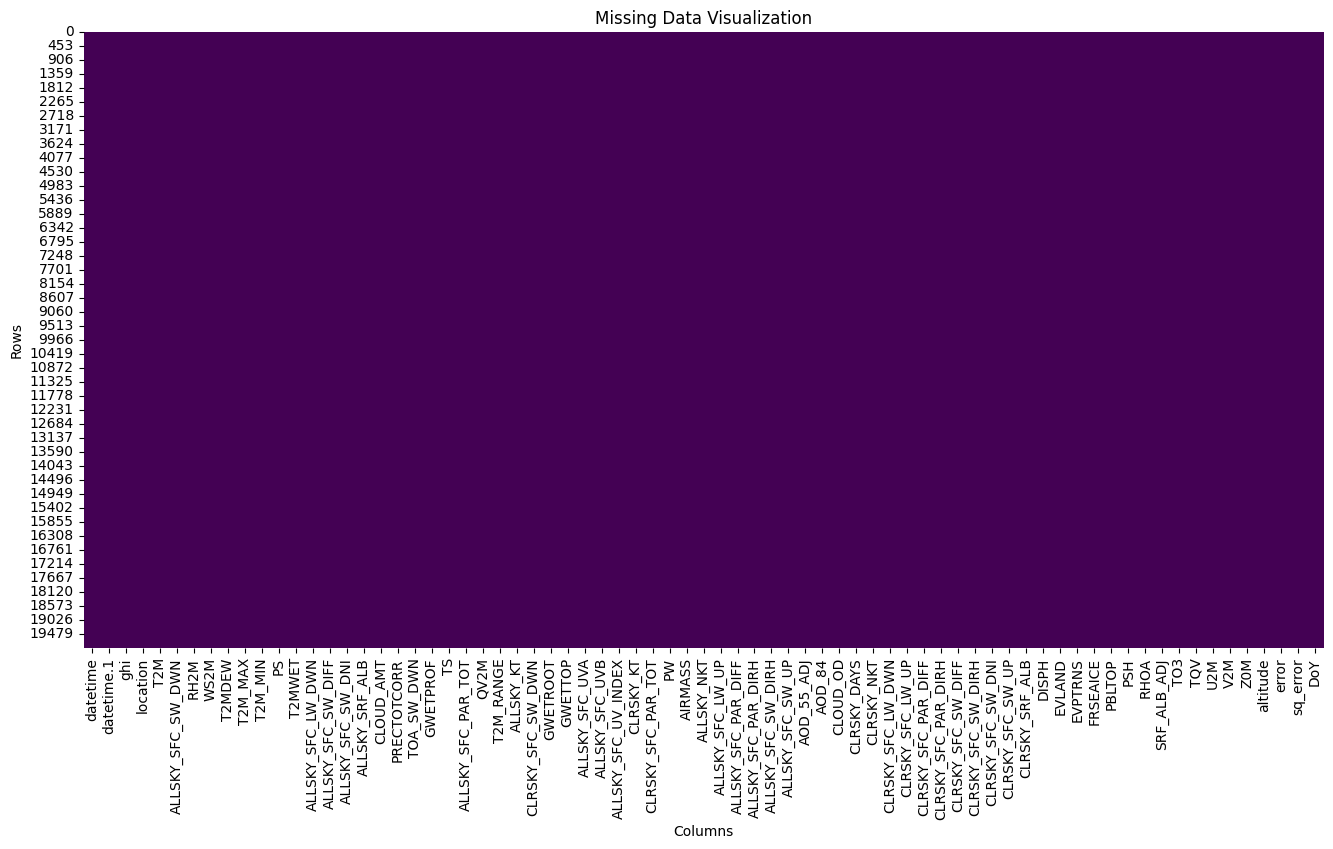

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your final dataframe is named 'df_final'
plt.figure(figsize=(16, 8))  # Adjust figure size as needed

# Create the heatmap using seaborn
sns.heatmap(merged_df.isnull(), cbar=False, cmap='viridis')

# Customize the plot
plt.title('Missing Data Visualization')
plt.xlabel('Columns')
plt.ylabel('Rows')

plt.show()

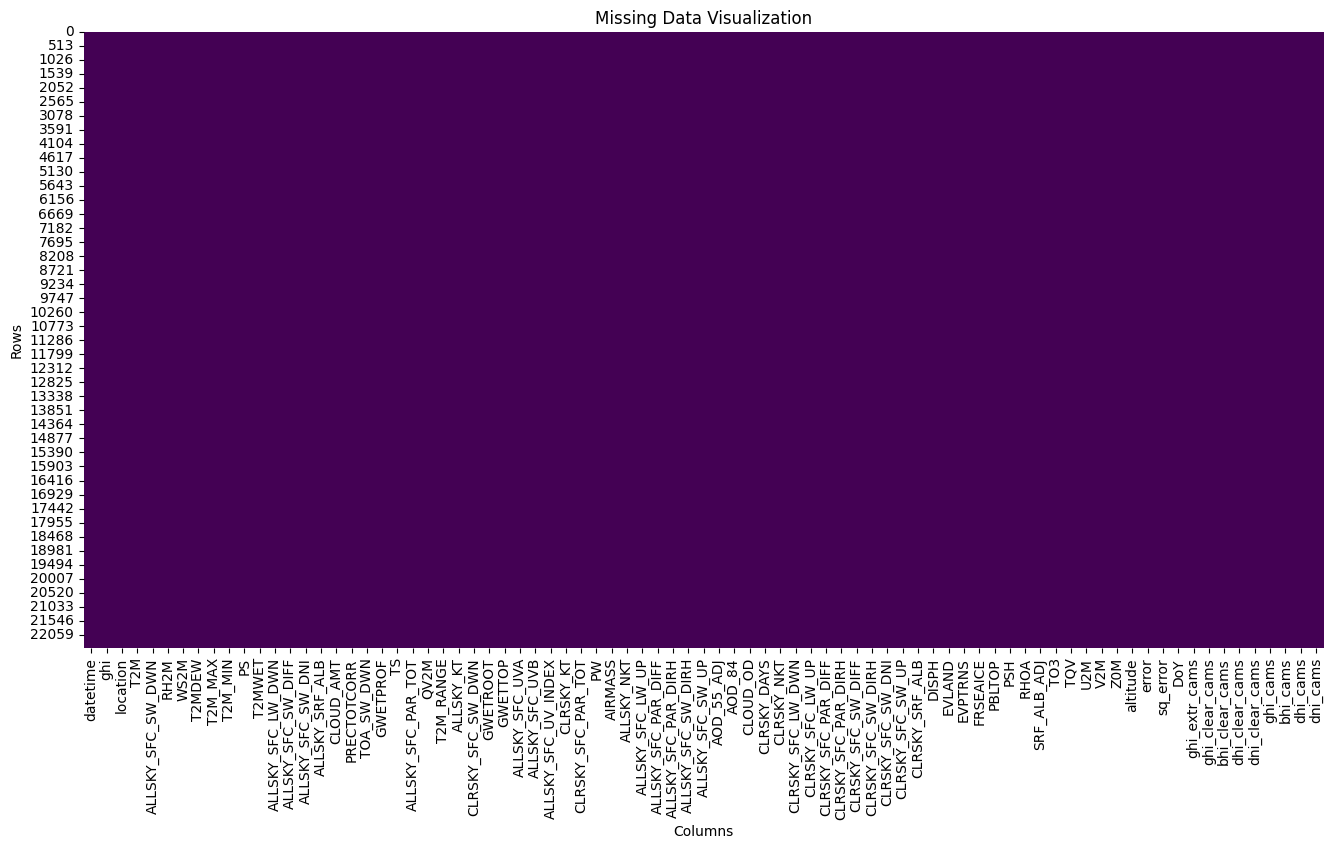

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your final dataframe is named 'df_final'
plt.figure(figsize=(16, 8))  # Adjust figure size as needed

# Create the heatmap using seaborn
sns.heatmap(df_final.isnull(), cbar=False, cmap='viridis')

# Customize the plot
plt.title('Missing Data Visualization')
plt.xlabel('Columns')
plt.ylabel('Rows')

plt.show()

In [ ]:
df_final.to_csv('all_locations_train_data.csv')

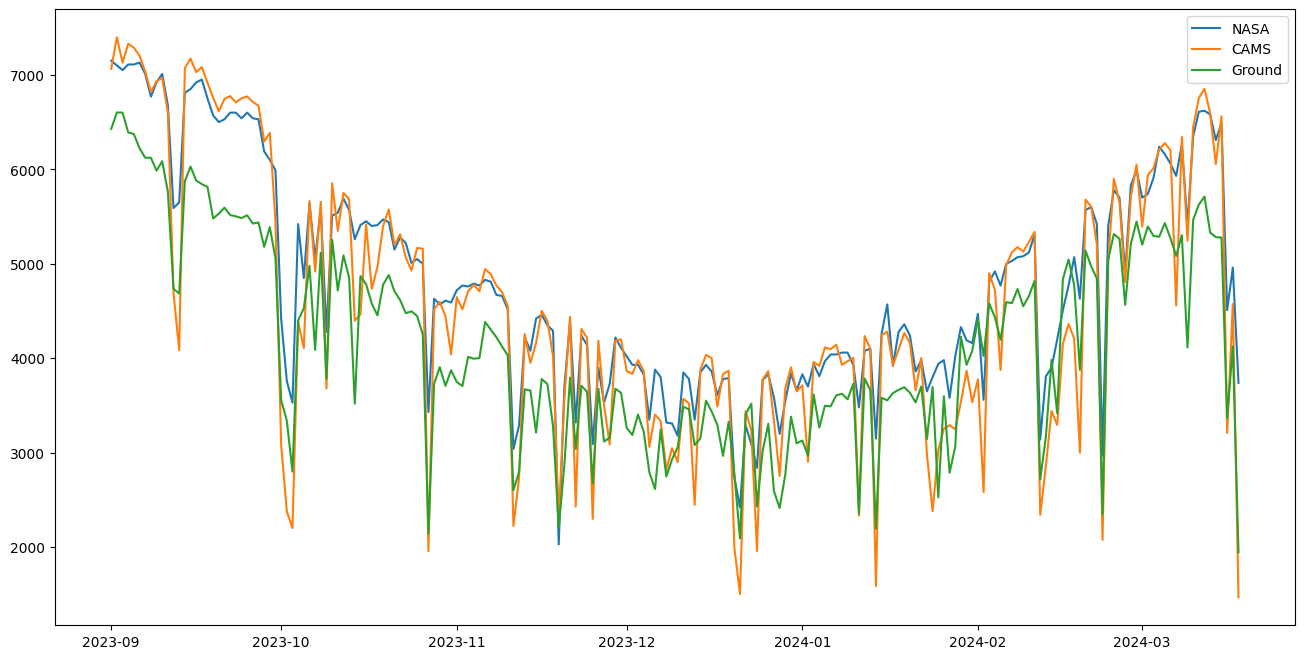

In [ ]:
# plot 200 values nasa ground and cams ghi on one plot

plt.figure(figsize=(16, 8))
plt.plot(nasa_df.iloc[:200].index, nasa_df.iloc[:200]['ghi_nasa'], label='NASA')
plt.plot(cams_df.iloc[:200].index, cams_df.iloc[:200]['ghi'], label='CAMS')
plt.plot(df.iloc[:200].index, df.iloc[:200]['ghi'], label='Ground')
plt.legend()
plt.show()